## 布林带日内交易策略_模拟运行20220601
### 设置操作标的：context.stockpool = ['002060.SZ']

In [1]:
from tick_trade_api import TradeAPI
# 输入指定账户
# trade_api=TradeAPI('376000093011',order_policy=MarketPolicy)
trade_api=TradeAPI('79644908',order_policy=MarketPolicy)


In [9]:
source_code="""

# 初始化函数
def init(context):
    #设置Boll模型参数
    context.timeperiod = 20 
    context.nbdevup = 2 
    context.nbdevdn = 2    
    # 运作周期
    context.runstep = 3
    # 设置基准收益
    #set_benchmark('000300.SH')
    #set_benchmark(002060.SZ')
    # 设置操作标的：
    context.stockpool = ['002060.SZ']
    
    # 设置手续费
    set_commission(PerShare(type='stock',cost=0.00025))
    #设置可变滑点1%，表示买入价为实际价格乘101%，卖出价为实际价格乘99%
    set_slippage(PriceSlippage(0.01))
    # 固定盈利
    context.win = 25 #盈利几个点卖出
    # 单笔买入仓位
    context.buypct = 0.1
    # 止盈
    context.stopwin = 100
    # 止损
    context.stoploss = 0.13  
    
    
    # 设置初识持仓
    set_holding_stocks(dict(zip(context.stockpool,[175500]*len(context.stockpool))))
    #set_holding_stocks(dict(zip(context.stockpool,[0]*len(context.stockpool))))
    
    # 记录日内买入日期时间
    context.stocktrade = {}
    for stock in context.stockpool:
        context.stocktrade[stock] = []
    
    # 获取当前持仓
    holdstock = list(context.portfolio.stock_account.positions.keys())
    print('持仓股票holdstock：', holdstock) 
    # 查询持仓情况
    market_value = context.portfolio.stock_account.market_value
    total_value = context.portfolio.stock_account.total_value
    stocklist = list(context.portfolio.stock_account.positions)
    print('当前持仓市值:', market_value, '持仓股票stocklist:', stocklist, '账户总资产:', int(total_value))
    
def handle_bar(context, bar_dict):    
    # 导入Python-talib库
    import talib
    # 获取当前分钟
    date = get_datetime().strftime('%Y-%m-%d %H:%M:%S')
    time1 = get_datetime().strftime('%M')
    time = get_datetime().strftime('%M')

    # 一、判断盈亏条件
    # 1.1 止盈止损
    # 获取当前持仓
    holdstock = list(context.portfolio.stock_account.positions.keys())
    for stock in holdstock:
        # 获取数据
        df = history(stock, ['close'], 2, '1m', True, 'pre', is_panel=1)
        new_price = df['close'].iloc[-1]
        # 获取成本价
        cost_basis = context.portfolio.positions[stock].cost_basis

        # 获取可卖股数等持仓情况
        amount = context.portfolio.positions[stock].amount
        available_amount = context.portfolio.positions[stock].available_amount
        market_value = context.portfolio.stock_account.market_value
        total_value = context.portfolio.stock_account.total_value
        stocklist = list(context.portfolio.stock_account.positions)
        
        
        if new_price/cost_basis-1>context.stopwin and available_amount>0:
            # 卖出所有股票
            print("止盈卖出 %s" % (stock), available_amount, '股')
            order(stock,-available_amount)
            # 移除本股票本轮交易时间记录
            context.stocktrade[stock] = []

        elif new_price/cost_basis-1< -context.stoploss and available_amount>0:
            # 卖出该股全部
            print("止损卖出 %s" % (stock), available_amount, '股')
            order(stock,-available_amount)
            # 移除本股票本轮交易时间记录
            context.stocktrade[stock] = []
    
            amount = context.portfolio.positions[stock].amount
            available_amount = context.portfolio.positions[stock].available_amount
            market_value = context.portfolio.stock_account.market_value
            total_value = context.portfolio.stock_account.total_value
            stocklist = list(context.portfolio.stock_account.positions)
            print('持仓股数:', amount, '可卖股数:', available_amount, '持仓股票', stocklist, '账户总资产:', int(total_value))
            
    # 1.2 达到获利目标后回落卖出
    # 获取当前持仓
    holdstock = list(context.portfolio.stock_account.positions.keys())
    for stock in holdstock:
        # 获取数据
        df = history(stock, ['close'], 2, '1m', True, 'pre', is_panel=1)
        new_price = df['close'].iloc[-1]
        # 获取成本价
        cost_basis = context.portfolio.positions[stock].cost_basis

        # 获取可卖股数等持仓情况
        available_amount = context.portfolio.positions[stock].available_amount
        market_value = context.portfolio.stock_account.market_value
        total_value = context.portfolio.stock_account.total_value
        # 取交易时间数据
        #print('context.stocktrade[stock]:', context.stocktrade[stock])


        if len(context.stocktrade[stock])>0:
            d1 = context.stocktrade[stock][0]
            dd1 = d1[:4]+d1[5:7]+d1[8:10]+' '+d1[11:16]
            dd2 = date

            df = get_price(stock, dd1, dd2,'1m', ['close', 'open', 'low', 'high'], skip_paused = False, fq = 'pre', is_panel = 1)
            new_price = df['close'].iloc[-1]

            # 计算本轮首次买入后至最新价期间的最高价及最大涨幅%
            max_price = df['high'].max()
            max_zf = (max_price-cost_basis)/cost_basis*100
            # 当最大涨幅大于context.win时候
            if max_zf>context.win and max_zf<40:
                # 计算本轮首次买入后至最新价期间的冲高回落幅度%
                hlfd = ((max_price-new_price)/(max_price-cost_basis))*100
                if hlfd > 20 and available_amount>0:
                    # 卖出该股全部
                    print("回落卖出:{},卖出价格:{},毛盈利{}%".format(stock,new_price,int(10000*(new_price/cost_basis -1))/100))
                    order(stock,-available_amount)
                    # 移除本股票本轮交易时间记录
                    context.stocktrade[stock] = []                    
                   
                    amount = context.portfolio.positions[stock].amount
                    available_amount = context.portfolio.positions[stock].available_amount
                    market_value = context.portfolio.stock_account.market_value
                    total_value = context.portfolio.stock_account.total_value
                    stocklist = list(context.portfolio.stock_account.positions)
                    print('持仓股数:', amount, '可卖股数:', available_amount, '持仓股票列表', stocklist, '账户总资产:', int(total_value))

            # 当最大涨幅大于等于40%时候
            if max_zf>=40:
                # 计算本轮首次买入后至最新价期间的冲高回落幅度%
                hlfd = ((max_price-new_price)/(max_price-cost_basis))*100
                if hlfd > 10 and available_amount>0:
                    # 卖出该股全部
                    print("回落卖出:{},卖出价格:{},毛盈利{}%".format(stock,new_price,int(10000*(new_price/cost_basis -1))/100))
                    order(stock,-available_amount)
                    # 移除本股票本轮交易时间记录
                    context.stocktrade[stock] = []
                    
                    amount = context.portfolio.positions[stock].amount
                    available_amount = context.portfolio.positions[stock].available_amount
                    market_value = context.portfolio.stock_account.market_value
                    total_value = context.portfolio.stock_account.total_value
                    stocklist = list(context.portfolio.stock_account.positions)
                    print('持仓股数:', amount, '可卖股数:', available_amount, '持仓股票列表', stocklist, '账户总资产:', int(total_value))


    
    # 二、布林带日内交易策略
    # 循环股票
    print('context.stockpool:', context.stockpool)
    for stock in context.stockpool:
        # 获取成本价
        cost_basis = context.portfolio.positions[stock].cost_basis

        # 获取数据
        df = history(stock, ['close','high','low'], 2400,'1m', True, 'pre', is_panel=1)
        # 提取数据
        close_price = df['close']
        high_price = df['high']
        low_price = df['low']
        new_price = df['close'].iloc[-1]
        
        # 导入Python-talib库
        import talib
        import numpy as np
        # 计算指标，获取BOLL值
        available_amount = context.portfolio.positions[stock].available_amount
        upperband, middleband, lowerband = talib.BBANDS(close_price.values, timeperiod=context.timeperiod, nbdevup=context.nbdevup, nbdevdn=context.nbdevdn)
        T_value = upperband-lowerband
        T_value = T_value[19:]
        mean = np.mean(T_value)
        new = T_value[-1]
        
        if T_value[-2] >T_value[-1] and new<mean and new_price<lowerband[-1]:            
            order_percent(stock, context.buypct)
            total_value = context.portfolio.stock_account.total_value
            print(stock,'当前处于相对低点{}'.format(new_price),'买入股票', '账户总资产:', int(total_value))
            # 记录这次买入时间
            context.stocktrade[stock].append(date)
        elif available_amount>0 and T_value[-2] >T_value[-1] and new<mean and new_price>upperband[-1]:
            print(stock,'当前处于相对高点{}'.format(new_price))
            order_percent(stock, -context.buypct)
            # 记录这次卖出时间
            context.stocktrade[stock].append(date)
            market_value = context.portfolio.stock_account.market_value
            total_value = context.portfolio.stock_account.total_value
            print(stock,"布林相对高点卖出:{},卖出价格:{},毛盈利{}%".format(stock,new_price,int(10000*(new_price/cost_basis -1))/100))
            print('持仓股票市值', market_value ,'账户总资产:', int(total_value))
            # 移除本股票本轮交易时间记录
            context.stocktrade[stock] = []
            
            
# 收盘后运行函数,用于储存自定义参数、全局变量,执行盘后选股等
def after_trading(context):
    
    log.info('一天结束')            

"""




In [7]:
# 系统重置
try:
    import shutil
    shutil.rmtree('persist/研究环境策略')
except:
    pass


In [4]:
# 模拟运行
rtrade = research_trade('研究环境策略', source_code, capital_base=float(8939000), frequency='MINUTE', trade_api=trade_api)#trade_api可传入List[TradeAPI]，实现多账户交易


2022-06-01 13:09:34.648521 - INFO - 开始research_trade运行...
2022-06-01 00:00:00.000000 - INFO - 初始化002060.SZ持仓175500股
2022-06-01 00:00:00.000000 - INFO - 持仓股票holdstock： ['002060.SZ']
2022-06-01 00:00:00.000000 - INFO - 当前持仓市值: 1447875.0 持仓股票stocklist: ['002060.SZ'] 账户总资产: 10386875
2022-06-01 13:09:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:10:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:11:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:12:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:13:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:14:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:15:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:16:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:17:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:18:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:19:00.000000 - I

2022-06-01 15:30:00.000000 - INFO - 一天结束
2022-06-01 15:30:00.000000 - INFO - 结束research_trade运行...


In [ ]:
# 模拟运行
#rtrade = research_trade('研究环境策略', source_code, capital_base=float(10000000), frequency='MINUTE', trade_api=trade_api)#trade_api可传入List[TradeAPI]，实现多账户交易


2022-05-30 00:00:00.000000 - INFO - 初始化002060.SZ持仓175500股
2022-05-30 00:00:00.000000 - INFO - 持仓股票holdstock： ['002060.SZ']
2022-05-30 00:00:00.000000 - INFO - 当前持仓市值: 1351350.0 持仓股票stocklist: ['002060.SZ'] 账户总资产: 5902350
2022-05-30 09:31:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:32:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:33:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:34:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:35:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:36:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:37:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:38:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:39:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:40:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:41:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 09:42:00.

2022-05-30 11:27:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 11:28:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 11:29:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 11:30:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:01:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:02:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:03:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:04:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:05:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:06:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:07:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:08:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:09:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:10:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 13:11:00.000000 - INFO 

2022-05-30 14:56:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 14:57:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 14:58:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 14:59:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 15:00:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-30 15:30:00.000000 - INFO - 一天结束
2022-05-31 09:31:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:32:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:33:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:34:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:35:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:36:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:37:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:38:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 09:39:00.000000 - INFO - context.stockpool: ['00206

2022-05-31 11:25:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 11:26:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 11:27:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 11:28:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 11:29:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 11:30:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:01:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:02:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:03:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:04:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:05:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:06:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:07:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:08:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 13:09:00.000000 - INFO 

2022-05-31 14:54:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 14:55:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 14:56:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 14:57:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 14:58:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 14:59:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 15:00:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-05-31 15:30:00.000000 - INFO - 一天结束
2022-06-01 09:31:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 09:32:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 09:33:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 09:34:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 09:35:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 09:36:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 09:37:00.000000 - INFO - context.stockpool: ['00206

2022-06-01 11:23:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 11:24:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 11:25:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 11:26:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 11:27:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 11:28:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 11:29:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 11:30:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:01:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:02:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:03:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:04:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:05:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:06:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 13:07:00.000000 - INFO 

2022-06-01 14:51:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:52:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:53:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:54:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:55:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:56:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:57:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:58:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 14:59:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 15:00:00.000000 - INFO - context.stockpool: ['002060.SZ']
2022-06-01 15:30:00.000000 - INFO - 一天结束


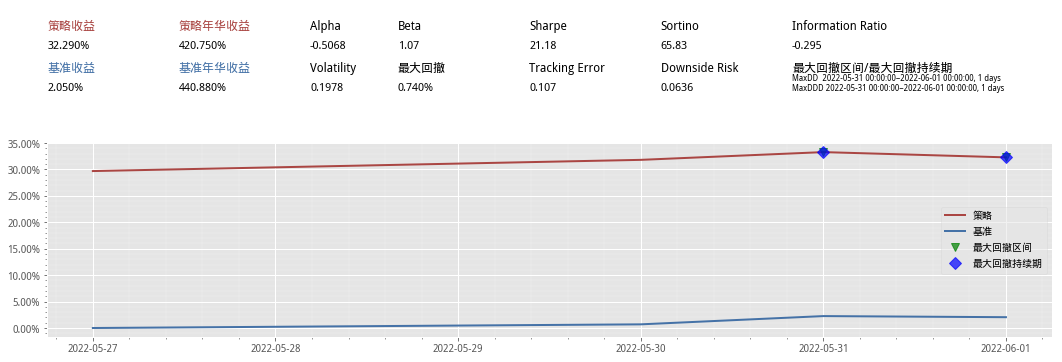

{'analyser': {'benchmark_portfolio':                 close  unit_net_value
  2022-05-27  4001.2988        1.000000
  2022-05-30  4029.0179        1.006928
  2022-05-31  4091.5176        1.022547
  2022-06-01  4083.1772        1.020463,
  'portfolio':                     cash  market_value  static_unit_net_value   total_value  \
  date                                                                          
  2022-05-27  4.551000e+06     1351350.0                 1.0000  5.902350e+06   
  2022-05-30  4.551000e+06     1447875.0                 1.2969  5.998875e+06   
  2022-05-31  4.551000e+06     1514565.0                 1.3181  6.065565e+06   
  2022-06-01  3.949651e+06     2070738.0                 1.3328  6.020389e+06   
  
              unit_net_value      units  
  date                                   
  2022-05-27        1.296935  4551000.0  
  2022-05-30        1.318144  4551000.0  
  2022-05-31        1.332798  4551000.0  
  2022-06-01        1.322872  4551000.0  ,
  'stock_

In [10]:
# 回测运行
# research_strategy(source_code, start_date=None, end_date=None, capital_base=100000, frequency='DAILY', stock_market='STOCK', benchmark=None)
research_strategy(source_code, start_date='20220530', end_date='20220601', capital_base=float(4551000), frequency='MINUTE', stock_market='STOCK', benchmark=None)


In [ ]:
# 回测运行
# research_strategy(source_code, start_date=None, end_date=None, capital_base=100000, frequency='DAILY', stock_market='STOCK', benchmark=None)
#research_strategy(source_code, start_date='20191230', end_date='20220527', capital_base=float(1000000), frequency='MINUTE', stock_market='STOCK', benchmark=None)
